In [1]:
# ======================================================
# Used Cars Project - Step 1: Load & Preprocess Dataset
# ======================================================

import pandas as pd
import numpy as np

# Because dataset is too large, we load selected columns only
cols = ['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
        'fuel', 'odometer', 'transmission', 'drive', 'type', 'state']

# Load CSV in chunks (processing big data efficiently)
chunk_size = 50_000
df_list = []

for chunk in pd.read_csv("vehicles.csv", usecols=cols, chunksize=chunk_size):
    chunk = chunk.dropna(subset=['price', 'year'])      # target & essential data
    chunk = chunk[chunk['price'] > 100]                 # remove junk values
    chunk = chunk[chunk['price'] < 200000]              # remove extreme prices
    chunk = chunk[chunk['year'] >= 1990]                # keep modern cars
    df_list.append(chunk)

# Combine all chunks into single DataFrame
df = pd.concat(df_list, ignore_index=True)

print("Shape before further cleaning:", df.shape)
df.head()

# Fill missing categorical values with 'unknown'
cat_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
            'transmission', 'drive', 'type', 'state']

for col in cat_cols:
    df[col] = df[col].fillna('unknown')

# Fill missing odometer with median
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

print("Null values remaining:\n", df.isnull().sum())
df.head()

df.to_csv("used_cars_clean.csv", index=False)
print("Clean dataset saved successfully!")
print("Final shape:", df.shape)


Shape before further cleaning: (377323, 12)
Null values remaining:
 price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
state           0
dtype: int64
Clean dataset saved successfully!
Final shape: (377323, 12)


Performing EDA on key numerical features...


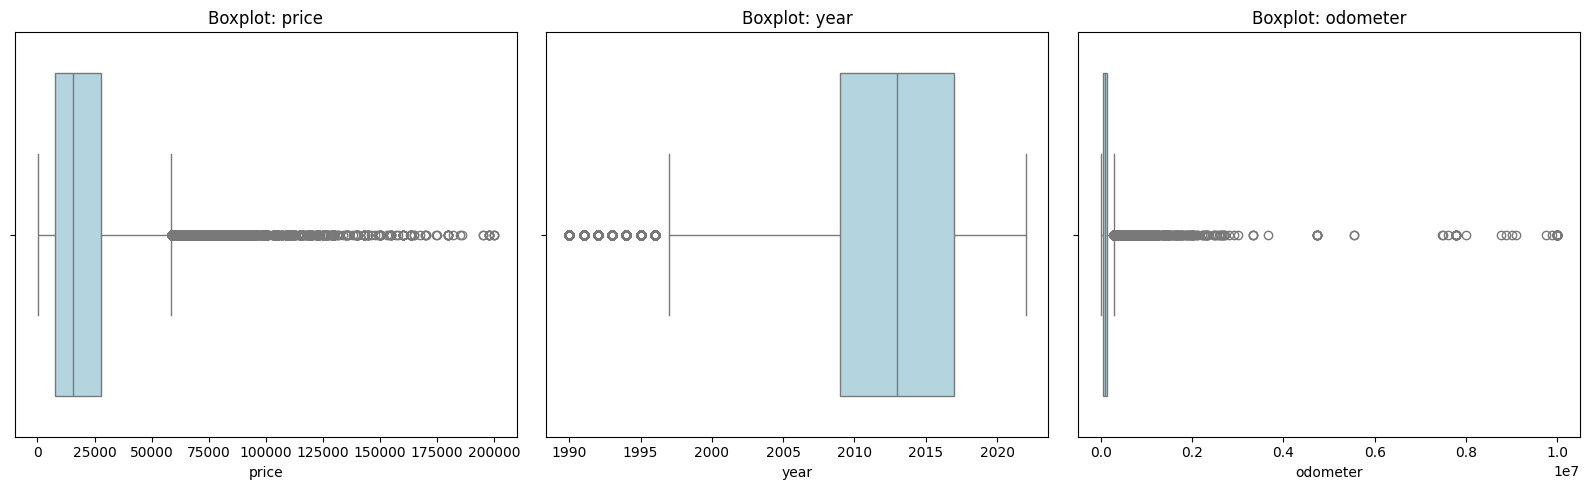

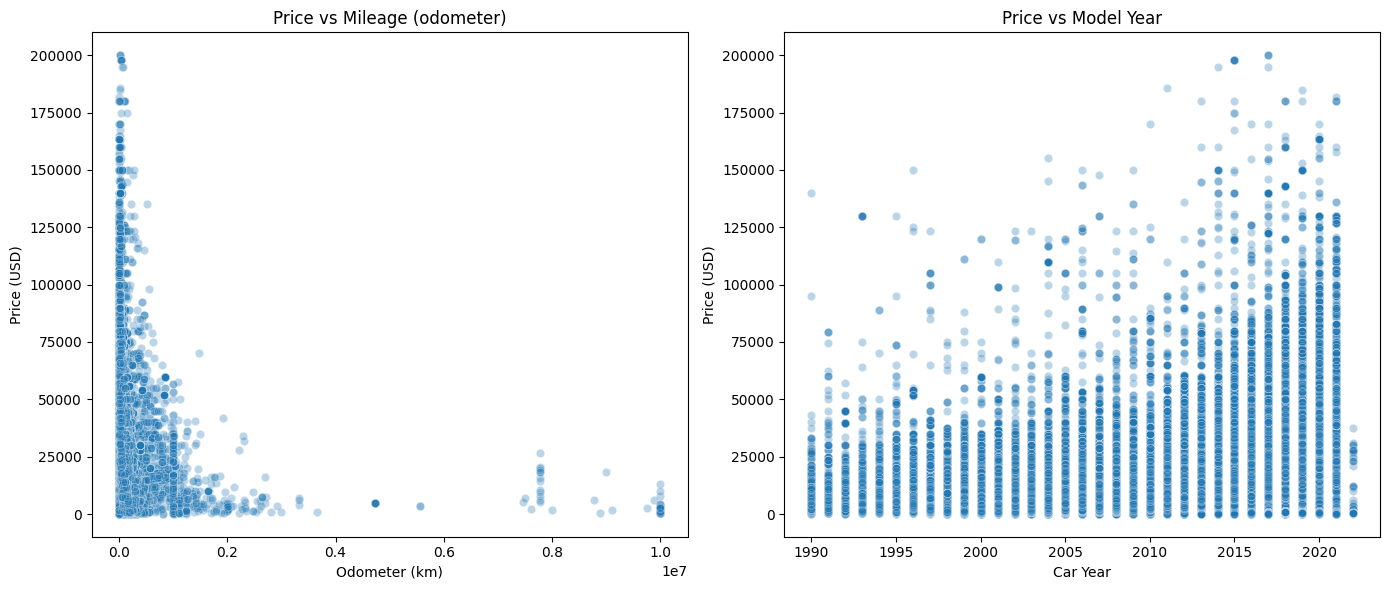

EDA Visualizations completed successfully!


In [2]:
# ======================================================
# STEP 1.5: Exploratory Data Analysis (EDA)
# ======================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("Performing EDA on key numerical features...")

# ---- BOX PLOTS FOR OUTLIERS ----
numeric_cols = ['price', 'year', 'odometer']

plt.figure(figsize=(16, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# ---- SCATTER PLOTS FOR RELATIONSHIPS ----
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='odometer', y='price', alpha=0.3)
plt.title("Price vs Mileage (odometer)")
plt.xlabel("Odometer (km)")
plt.ylabel("Price (USD)")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='year', y='price', alpha=0.3)
plt.title("Price vs Model Year")
plt.xlabel("Car Year")
plt.ylabel("Price (USD)")

plt.tight_layout()
plt.show()

print("EDA Visualizations completed successfully!")


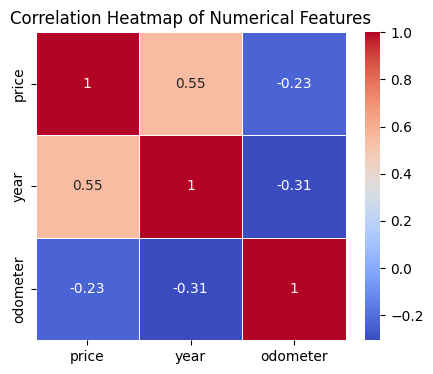

C:\Users\saksh\AppData\Local\Temp\ipykernel_22156\2633829087.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette="viridis")


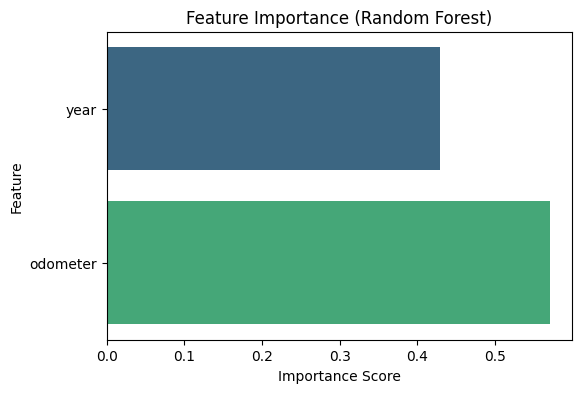

Additional EDA completed successfully!


In [3]:
# ======================================================
# STEP 1.6: Additional EDA - Correlation & Feature Importance
# ======================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Select numeric features for heatmap
numeric_cols = ['price', 'year', 'odometer']
corr = df[numeric_cols].corr()

# ---- CORRELATION HEATMAP ----
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# ---- FEATURE IMPORTANCE USING RANDOM FOREST REGRESSOR ----
X_temp = df[['year', 'odometer']]
y_temp = df['price']

rf_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
rf_model.fit(X_temp, y_temp)

importances = rf_model.feature_importances_
feat_names = ['year', 'odometer']

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feat_names, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("Additional EDA completed successfully!")


In [4]:
# ======================================================
# Step 3: Feature Engineering for Classification
# ======================================================

df = pd.read_csv("used_cars_clean.csv")

# Create price category labels
def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

# Drop high-cardinality columns not needed for models now
df = df.drop(['model'], axis=1)

print("Classes distribution:\n", df['price_category'].value_counts(normalize=True))
df.head()


# -----------------------

# Define features (X) and target (y)
X = df.drop(['price', 'price_category'], axis=1)  # keep price for regression later
y = df['price_category']

# Identify categorical columns
cat_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(exclude=['object']).columns

print("Categorical:", list(cat_columns))
print("Numerical:", list(num_columns))


# ---------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


# -----------------

# Build a transformed sample to check shape after encoding
X_train_sample = preprocessor.fit_transform(X_train)
X_test_sample = preprocessor.transform(X_test)

print("After encoding:")
print("Train shape:", X_train_sample.shape)
print("Test shape:", X_test_sample.shape)


Classes distribution:
 price_category
midrange    0.442093
budget      0.355115
premium     0.202792
Name: proportion, dtype: float64
Categorical: ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'state']
Numerical: ['year', 'odometer']
Train size: (301858, 10)
Test size: (75465, 10)
After encoding:
Train shape: (301858, 139)
Test shape: (75465, 139)


Original shape: (377323, 12)
   price    year manufacturer                     model  condition  \
0  33590  2014.0          gmc  sierra 1500 crew cab slt       good   
1  22590  2010.0    chevrolet            silverado 1500       good   
2  39590  2020.0    chevrolet       silverado 1500 crew       good   
3  30990  2017.0       toyota      tundra double cab sr       good   
4  15000  2013.0         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer transmission    drive    type state  
0  8 cylinders  gas   57923.0        other  unknown  pickup    al  
1  8 cylinders  gas   71229.0        other  unknown  pickup    al  
2  8 cylinders  gas   19160.0        other  unknown  pickup    al  
3  8 cylinders  gas   41124.0        other  unknown  pickup    al  
4  6 cylinders  gas  128000.0    automatic      rwd   truck    al  

Class distribution (proportion):
price_category
midrange    0.442093
budget      0.355115
premium     0.202792
Name: proportion, dtype: float

C:\Users\saksh\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy   : 0.8053
Precision  : 0.8070
Recall     : 0.8003
F1-score   : 0.8034
ROC-AUC    : 0.9342
Log Loss   : 0.4826

===== CLASSIFICATION MODEL COMPARISON =====
                 Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC (OVR)  Log Loss
         Random Forest  0.831525   0.845156 0.819745  0.830509       0.950635  0.481921
                   KNN  0.810919   0.813976 0.807739  0.810718       0.928049  1.519772
    MLP Neural Network  0.805340   0.806972 0.800303  0.803419       0.934218  0.482567
         Decision Tree  0.793666   0.806154 0.777293  0.789072       0.918225  0.730108
Support Vector Machine  0.776519   0.774210 0.771972  0.773054            NaN       NaN
   Logistic Regression  0.775684   0.778309 0.766089  0.771639       0.910824  0.560075
     Gradient Boosting  0.767429   0.769430 0.755535  0.761745       0.909502  0.560820
           Naive Bayes  0.393692   0.523247 0.467195  0.368009       0.725354 13.387633


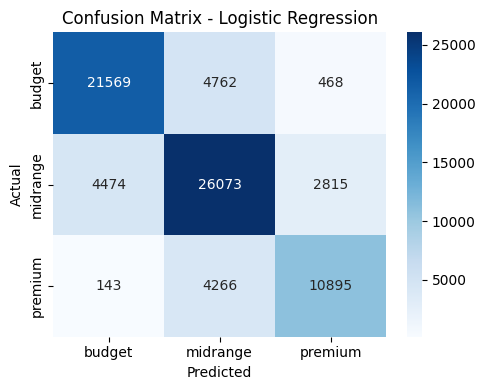

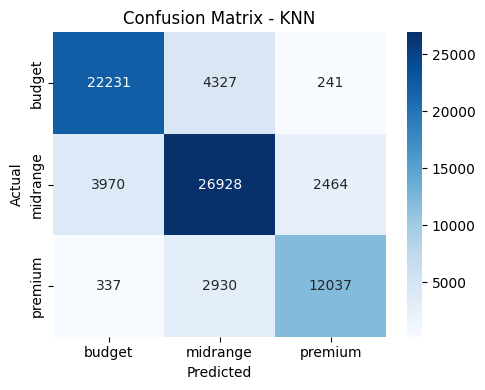

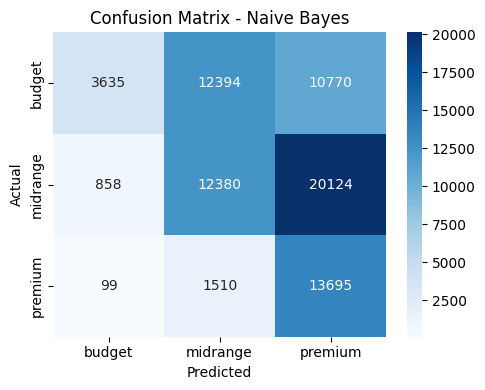

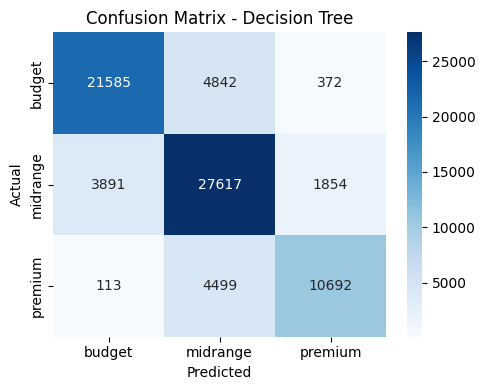

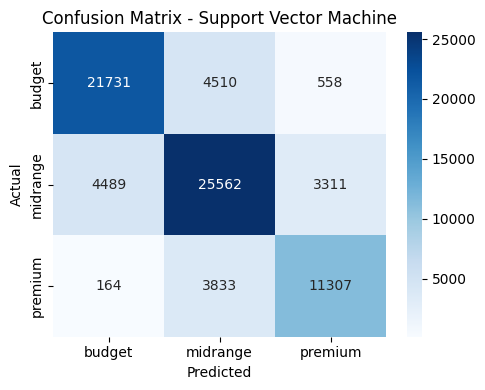

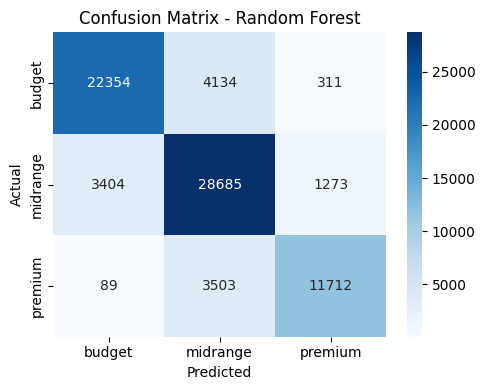

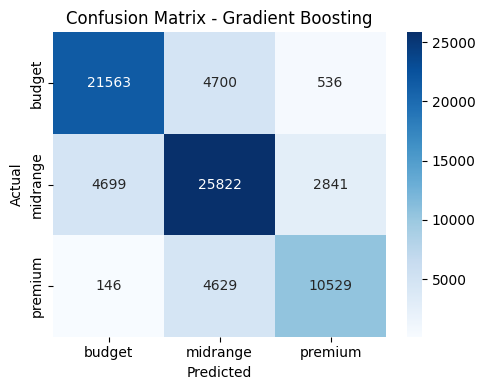

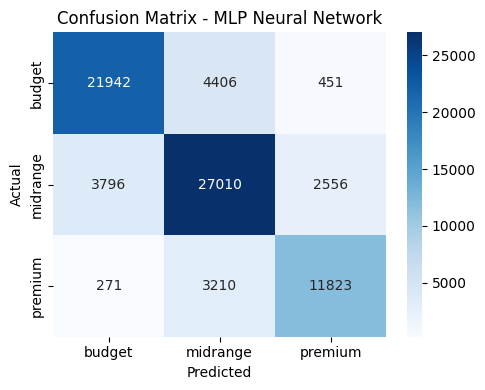

In [5]:
# ============================================================
# STEP 3: CLASSIFICATION MODELS (HUMAN-FRIENDLY + FASTER ALL)
# ============================================================

import pandas as pd
import numpy as np

# For splitting data
from sklearn.model_selection import train_test_split

# For scaling numeric columns
from sklearn.preprocessing import StandardScaler

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, log_loss
)

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. LOAD THE CLEANED DATASET
# ------------------------------------------------------------
df = pd.read_csv("used_cars_clean.csv")

print("Original shape:", df.shape)
print(df.head())

# ------------------------------------------------------------
# 2. CREATE CLASSIFICATION TARGET: price_category
# ------------------------------------------------------------
def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

print("\nClass distribution (proportion):")
print(df['price_category'].value_counts(normalize=True))

# Drop 'model' (too many unique values)
if 'model' in df.columns:
    df = df.drop(columns=['model'])

# ------------------------------------------------------------
# 3. SEPARATE FEATURES (X) AND TARGET (y)
# ------------------------------------------------------------
X = df.drop(columns=['price', 'price_category'])
y = df['price_category']

print("\nFeature columns:")
print(X.columns)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# ------------------------------------------------------------
# 4. ONE-HOT ENCODE CATEGORICAL COLUMNS
# ------------------------------------------------------------
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print("\nShape after one-hot encoding:", X_encoded.shape)

# ------------------------------------------------------------
# 5. SCALE NUMERICAL FEATURES
# ------------------------------------------------------------
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# ------------------------------------------------------------
# 6. TRAIN-TEST SPLIT
# ------------------------------------------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nFull Train shape:", X_train_full.shape)
print("Test shape      :", X_test.shape)

# ------------------------------------------------------------
# 7. CREATE SMALLER TRAINING SUBSETS
#    - 'all models' train on up to 150,000 rows
#    - 'heavy models' (GB, MLP, SVM) train on up to 20,000 rows
# ------------------------------------------------------------
sample_all = 150000
sample_heavy = 20000   # reduced for speed

if len(X_train_full) > sample_all:
    X_train_all = X_train_full.sample(n=sample_all, random_state=42)
    y_train_all = y_train_full.loc[X_train_all.index]
else:
    X_train_all = X_train_full
    y_train_all = y_train_full

if len(X_train_all) > sample_heavy:
    X_train_heavy = X_train_all.sample(n=sample_heavy, random_state=42)
    y_train_heavy = y_train_all.loc[X_train_heavy.index]
else:
    X_train_heavy = X_train_all
    y_train_heavy = y_train_all

print("\nTrain subset for normal models:", X_train_all.shape)
print("Train subset for heavy models :", X_train_heavy.shape)

# ------------------------------------------------------------
# 8. DEFINE CLASSIFICATION MODELS (with lighter SVM)
# ------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=12, random_state=42),

    # Lighter / faster SVM
    "Support Vector Machine": SVC(
        kernel='linear',      # faster in high-dimensional OHE space
        probability=False,    # no probability -> big speedup
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=120,
        max_depth=18,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=60,
        random_state=42
    ),
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(64,),
        max_iter=80,
        random_state=42
    )
}

# SVM is also treated as a heavy model now
heavy_models = ["Gradient Boosting", "MLP Neural Network", "Support Vector Machine"]

# ------------------------------------------------------------
# 9. TRAIN EACH MODEL AND CALCULATE METRICS
# ------------------------------------------------------------
results = []
conf_matrices = {}
class_names = ['budget', 'midrange', 'premium']

for name, model in models.items():
    print(f"\n==============================")
    print(f"Training model: {name}")
    print(f"==============================")
    
    if name in heavy_models:
        X_fit = X_train_heavy
        y_fit = y_train_heavy
    else:
        X_fit = X_train_all
        y_fit = y_train_all
    
    model.fit(X_fit, y_fit)
    
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    if y_prob is not None:
        ll = log_loss(y_test, y_prob)
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        except Exception as e:
            print("Could not compute ROC-AUC:", e)
            roc_auc = np.nan
    else:
        ll = np.nan
        roc_auc = np.nan
    
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"ROC-AUC    : {roc_auc:.4f}")
    print(f"Log Loss   : {ll:.4f}")
    
    results.append([
        name, acc, prec, rec, f1, roc_auc, ll
    ])
    
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    conf_matrices[name] = cm

# ------------------------------------------------------------
# 10. COMPARISON TABLE
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall",
    "F1 Score", "ROC-AUC (OVR)", "Log Loss"
])

results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\n===== CLASSIFICATION MODEL COMPARISON =====")
print(results_df.to_string(index=False))

# ------------------------------------------------------------
# 11. CONFUSION MATRICES
# ------------------------------------------------------------
for name, cm in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Full data shape: (377323, 12)
Sampled data shape: (10000, 12)
Encoded sample shape: (10000, 129)
PCA-transformed shape: (10000, 2)
Explained Variance by 2 PCs: 0.04411853293435575


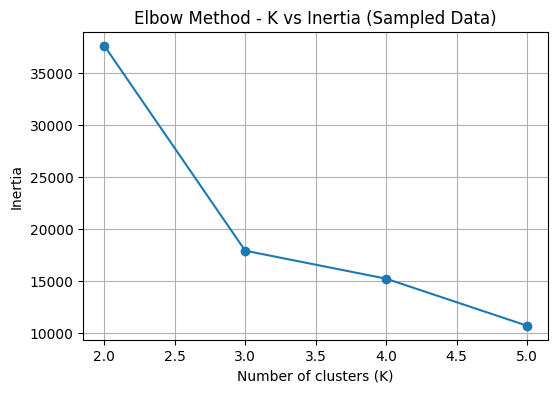

Silhouette Score for K=3 (sampled data): 0.4587


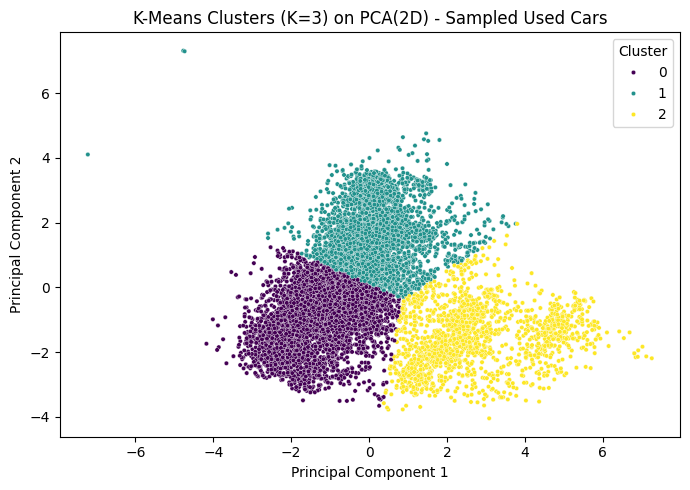

In [6]:
# ============================================================
# STEP 5: PCA + K-MEANS CLUSTERING (SAMPLED, CLEAN VERSION)
# ============================================================

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. LOAD CLEAN DATASET & CREATE price_category
# ------------------------------------------------------------
df = pd.read_csv("used_cars_clean.csv")

def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

# Drop 'model' to avoid extremely high cardinality
if 'model' in df.columns:
    df = df.drop(columns=['model'])

print("Full data shape:", df.shape)

# ------------------------------------------------------------
# 2. TAKE A RANDOM SAMPLE FOR CLUSTERING (10,000 ROWS)
# ------------------------------------------------------------
sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)
print("Sampled data shape:", df_sample.shape)

# ------------------------------------------------------------
# 3. PREPARE FEATURES FOR PCA + K-MEANS
# ------------------------------------------------------------
X_sample = df_sample.drop(columns=['price', 'price_category'])

# One-hot encode categorical features
X_sample_encoded = pd.get_dummies(X_sample, drop_first=True)
print("Encoded sample shape:", X_sample_encoded.shape)

# Scale features
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample_encoded)

# ------------------------------------------------------------
# 4. APPLY PCA (2 COMPONENTS) FOR VISUALIZATION
# ------------------------------------------------------------
pca = PCA(n_components=2)
X_sample_pca = pca.fit_transform(X_sample_scaled)

print("PCA-transformed shape:", X_sample_pca.shape)
print("Explained Variance by 2 PCs:", pca.explained_variance_ratio_.sum())

# ------------------------------------------------------------
# 5. ELBOW METHOD TO FIND A GOOD K (NOW K=2 TO 5)
# ------------------------------------------------------------
inertia_list = []
K_range = range(2, 6)  # 2, 3, 4, 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample_pca)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method - K vs Inertia (Sampled Data)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. CHOOSE K = 3 (3 MARKET SEGMENTS)
# ------------------------------------------------------------
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
sample_clusters = kmeans_final.fit_predict(X_sample_pca)

df_sample['cluster'] = sample_clusters

# ------------------------------------------------------------
# 7. SILHOUETTE SCORE
# ------------------------------------------------------------
sil_score = silhouette_score(X_sample_pca, sample_clusters)
print(f"Silhouette Score for K={optimal_k} (sampled data): {sil_score:.4f}")

# ------------------------------------------------------------
# 8. VISUALIZE CLUSTERS
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_sample_pca[:, 0],
    y=X_sample_pca[:, 1],
    hue=df_sample['cluster'],
    palette='viridis',
    s=10
)
plt.title("K-Means Clusters (K=3) on PCA(2D) - Sampled Used Cars")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Hierarchical clustering sample shape: (1000, 123)


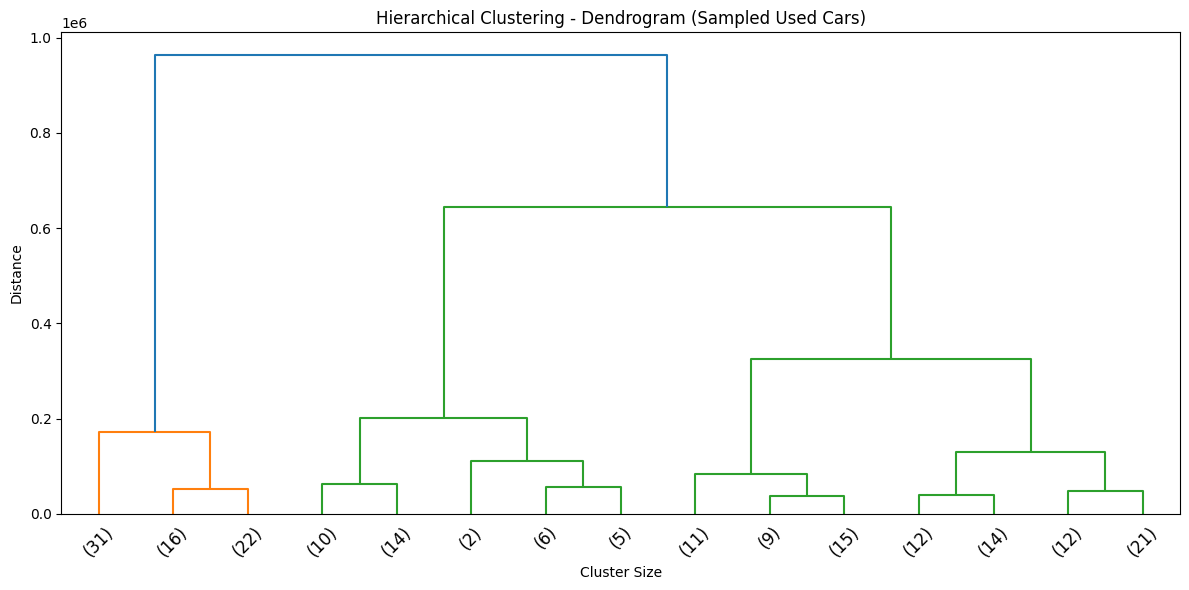

In [7]:
# ============================================================
# STEP 6: HIERARCHICAL CLUSTERING (DENDROGRAM)
# ============================================================

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# -------------------------------
# We take a smaller sample: 1000
# (Hierarchical is heavy on memory)
# -------------------------------
sample_size = 1000
df_hier = df.sample(n=sample_size, random_state=42)

# Use only numeric PCA data for distances
X_hier = df_hier.drop(columns=['price', 'price_category'], errors='ignore')
X_hier_enc = pd.get_dummies(X_hier, drop_first=True)

print("Hierarchical clustering sample shape:", X_hier_enc.shape)

# -------------------------------
# Create linkage matrix
# -------------------------------
linkage_matrix = linkage(X_hier_enc.iloc[:200], method='ward')
# (only 200 for clean visualization)

# -------------------------------
# Plot dendrogram
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix,
           truncate_mode='lastp',  # simplify tree
           p=15,                   # show last 15 merged clusters
           leaf_rotation=45)
plt.title("Hierarchical Clustering - Dendrogram (Sampled Used Cars)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [8]:
# ============================================================
# STEP 7: REGRESSION MODELS ON CAR PRICE
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------------------------------------
# 1. LOAD CLEAN DATA AGAIN (INDEPENDENT STEP)
# ------------------------------------------------------------
df = pd.read_csv("used_cars_clean.csv")

print("Original shape:", df.shape)
print(df.head())

# Recreate price_category (not used for regression, but for consistency)
def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

# Drop 'model' to reduce too many categories
if 'model' in df.columns:
    df = df.drop(columns=['model'])

# ------------------------------------------------------------
# 2. DEFINE FEATURES (X) AND TARGET (y_reg)
#    Target for regression = actual price (continuous)
# ------------------------------------------------------------
X_reg = df.drop(columns=['price', 'price_category'])
y_reg = df['price']

print("\nRegression feature columns:")
print(X_reg.columns)

# Separate numeric and categorical columns
cat_cols = X_reg.select_dtypes(include=['object']).columns.tolist()
num_cols = X_reg.select_dtypes(exclude=['object']).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# ------------------------------------------------------------
# 3. ONE-HOT ENCODE CATEGORICAL COLUMNS
# ------------------------------------------------------------
X_reg_encoded = pd.get_dummies(X_reg, columns=cat_cols, drop_first=True)

print("\nShape after encoding (Regression):", X_reg_encoded.shape)

# ------------------------------------------------------------
# 4. SCALE NUMERICAL COLUMNS
# ------------------------------------------------------------
scaler = StandardScaler()
X_reg_encoded[num_cols] = scaler.fit_transform(X_reg_encoded[num_cols])

# ------------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# ------------------------------------------------------------
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg,
    test_size=0.2,
    random_state=42
)

print("\nRegression Train shape:", X_train_reg.shape)
print("Regression Test shape :", X_test_reg.shape)

# ------------------------------------------------------------
# 6. DEFINE REGRESSION MODELS
# ------------------------------------------------------------
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=150, max_depth=20, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        random_state=42
    )
}

# ------------------------------------------------------------
# 7. TRAIN & EVALUATE REGRESSION MODELS
# ------------------------------------------------------------
reg_results = []

for name, model in reg_models.items():
    print(f"\n==============================")
    print(f"Training Regression Model: {name}")
    print(f"==============================")
    
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R^2  : {r2:.4f}")
    
    reg_results.append([name, mae, mse, rmse, r2])

# ------------------------------------------------------------
# 8. COMPARISON TABLE FOR REGRESSION
# ------------------------------------------------------------
reg_results_df = pd.DataFrame(reg_results, columns=[
    "Model", "MAE", "MSE", "RMSE", "R^2 Score"
])

reg_results_df = reg_results_df.sort_values(by="RMSE")
print("\n===== REGRESSION MODEL COMPARISON =====")
print(reg_results_df.to_string(index=False))


Original shape: (377323, 12)
   price    year manufacturer                     model  condition  \
0  33590  2014.0          gmc  sierra 1500 crew cab slt       good   
1  22590  2010.0    chevrolet            silverado 1500       good   
2  39590  2020.0    chevrolet       silverado 1500 crew       good   
3  30990  2017.0       toyota      tundra double cab sr       good   
4  15000  2013.0         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer transmission    drive    type state  
0  8 cylinders  gas   57923.0        other  unknown  pickup    al  
1  8 cylinders  gas   71229.0        other  unknown  pickup    al  
2  8 cylinders  gas   19160.0        other  unknown  pickup    al  
3  8 cylinders  gas   41124.0        other  unknown  pickup    al  
4  6 cylinders  gas  128000.0    automatic      rwd   truck    al  

Regression feature columns:
Index(['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'drive', 'typ

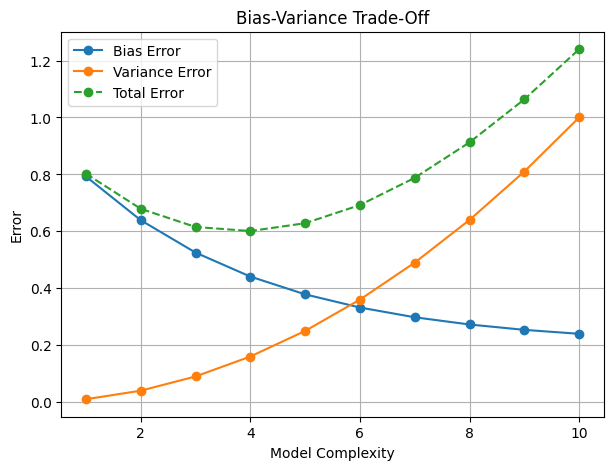

Bias decreases with more complex models,
Variance increases with more complex models,
Optimal model lies where total error is minimum.


In [9]:
# ============================================================
# STEP 8: BIAS-VARIANCE TRADE-OFF (SIMPLE VISUAL)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Fake data to simulate learning behavior
model_complexity = np.linspace(1, 10, 10)
bias_error = np.exp(-0.3 * model_complexity) * 0.8 + 0.2
variance_error = (model_complexity / 10) ** 2
total_error = bias_error + variance_error

plt.figure(figsize=(7,5))
plt.plot(model_complexity, bias_error, marker='o', label="Bias Error")
plt.plot(model_complexity, variance_error, marker='o', label="Variance Error")
plt.plot(model_complexity, total_error, marker='o', label="Total Error", linestyle='--')

plt.title("Bias-Variance Trade-Off")
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Short explanation for viva/report
print("Bias decreases with more complex models,")
print("Variance increases with more complex models,")
print("Optimal model lies where total error is minimum.")


C:\Users\saksh\AppData\Local\Temp\ipykernel_22156\3043271533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


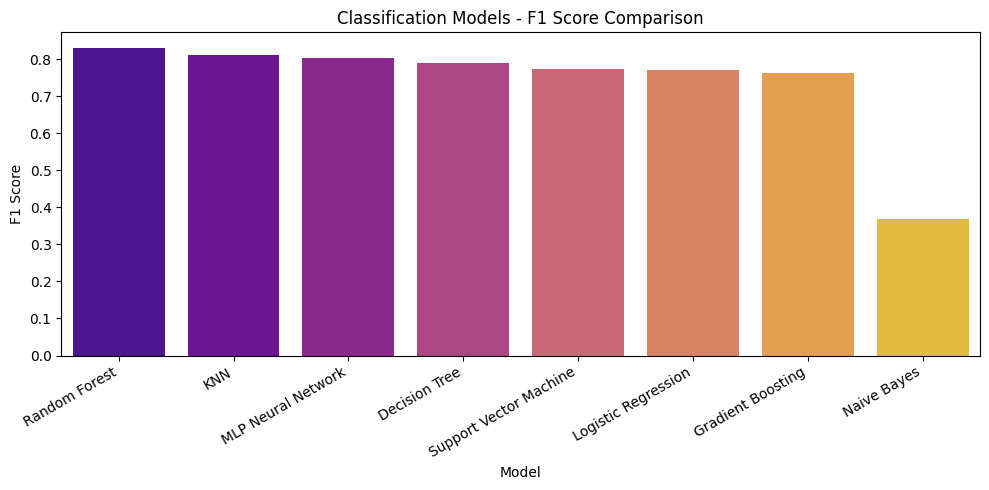

C:\Users\saksh\AppData\Local\Temp\ipykernel_22156\3043271533.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


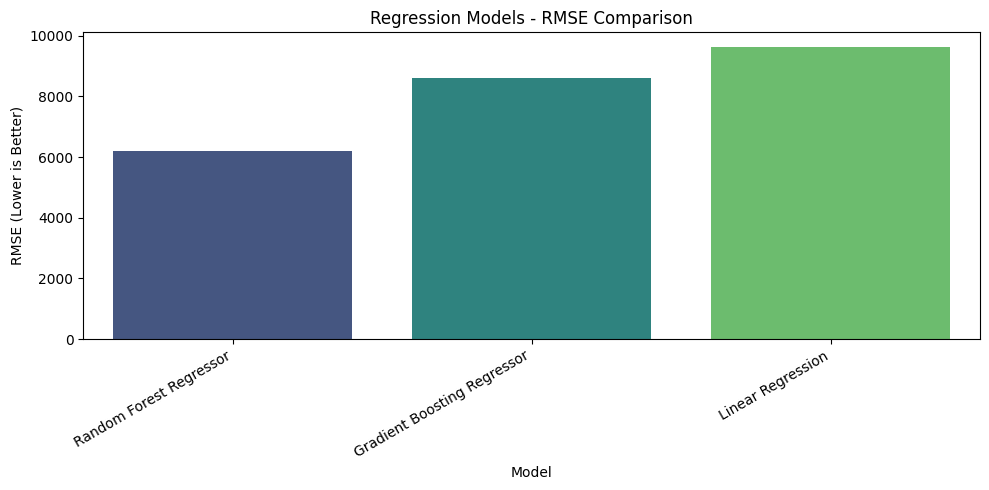


Summary Graphs Generated Successfully!


In [10]:
# ============================================================
# STEP 9: FINAL MODEL PERFORMANCE SUMMARY (PLOTS)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1️⃣ Classification Comparison ----------
plt.figure(figsize=(10,5))
sns.barplot(
    x=results_df['Model'], 
    y=results_df['F1 Score'],
    palette="plasma"
)
plt.title("Classification Models - F1 Score Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# ---------- 2️⃣ Regression Comparison ----------
plt.figure(figsize=(10,5))
sns.barplot(
    x=reg_results_df['Model'], 
    y=reg_results_df['RMSE'],
    palette="viridis"
)
plt.title("Regression Models - RMSE Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.show()

print("\nSummary Graphs Generated Successfully!")
